In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Embedding, Bidirectional, RNN, LSTMCell, Dense

In [2]:
def preprocessing():
    ''' Preprocess original data files: delete unwanted columns, convert
        training labels to index
    '''
    df_labeled = pd.read_csv('data/train_origin.csv')
    LABEL = list(set(df_labeled['Category']))
    df_labeled['Category'] = df_labeled['Category'].apply(lambda x: LABEL.index(x))
    del df_labeled['ArticleId']
    df_labeled.to_csv('data/train.csv', index=False)

    df_test = pd.read_csv('data/test_origin.csv')
    del df_test['ArticleId']
    df_test.to_csv('data/test.csv', index=False)
    print('\nFinish processing original files.\n')
    
    return LABEL

LABEL = preprocessing()


Finish processing original files.



In [3]:
# Read the data using tf.data
labeled_dataset = tf.data.experimental.CsvDataset('data/train.csv', ['None', 0], header=True)
test_dataset = tf.data.experimental.CsvDataset('data/test.csv', ['None'], header=True)

In [4]:
# Tokenize the data, get vocabulary for encoding later
tokenizer = tfds.features.text.Tokenizer()

vocabulary = set()
for text, label in labeled_dataset:
    some_tokens = tokenizer.tokenize(text.numpy())
    vocabulary.update(some_tokens)

for (text,) in test_dataset:
    some_tokens = tokenizer.tokenize(text.numpy())
    vocabulary.update(some_tokens)
print('Finish tokenization.\n')

vocab_size = len(vocabulary)
print('There are %d words in vocabulary.\n' % vocab_size)

Finish tokenization.

There are 29457 words in vocabulary.



In [5]:
# Encode the training/validation data
encoder = tfds.features.text.TokenTextEncoder(vocabulary)

def encode(text, label):
    encoded_text = encoder.encode(text.numpy())
    return encoded_text, label

def encode_map_fn(text, label):
    encoded_text, label = tf.py_function(encode, inp=[text, label], Tout=(tf.int32, tf.int32))
    encoded_text.set_shape([None])
    label.set_shape([])

    return encoded_text, label
labeled_encoded = labeled_dataset.map(encode_map_fn)
print('Finish encoding.\n')

Finish encoding.



In [6]:
batch_size = 64
val_size = 500
buffer_size = 2000

train_data = labeled_encoded.skip(val_size).shuffle(buffer_size)
train_data = train_data.padded_batch(batch_size)

val_data = labeled_encoded.take(val_size)
val_data = val_data.padded_batch(batch_size)

In [7]:
vocab_size += 1
print(vocab_size)

29458


In [8]:
# Define model
embed_size = 64
hidden_units = 64
dense_hiddens = [64, 32]
classes = len(LABEL)

model = tf.keras.Sequential()
model.add(Embedding(vocab_size, embed_size))
model.add(Bidirectional(RNN(LSTMCell(hidden_units))))
for units in dense_hiddens:
    model.add(Dense(units, activation='relu'))
model.add(Dense(classes))

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          1885312   
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 165       
Total params: 1,961,861
Trainable params: 1,961,861
Non-trainable params: 0
_________________________________________________________________


In [9]:
history = model.fit(train_data, epochs=8, validation_data=val_data)

Epoch 1/8
16/16 [==============================] - 40s 3s/step - loss: 1.6049 - accuracy: 0.2242 - val_loss: 1.5915 - val_accuracy: 0.2540
Epoch 2/8
16/16 [==============================] - 40s 2s/step - loss: 1.4974 - accuracy: 0.2970 - val_loss: 1.2310 - val_accuracy: 0.4180
Epoch 3/8
16/16 [==============================] - 40s 3s/step - loss: 1.0751 - accuracy: 0.4889 - val_loss: 0.9639 - val_accuracy: 0.4460
Epoch 4/8
16/16 [==============================] - 40s 2s/step - loss: 0.8065 - accuracy: 0.5889 - val_loss: 0.8894 - val_accuracy: 0.6480
Epoch 5/8
16/16 [==============================] - 36s 2s/step - loss: 0.5804 - accuracy: 0.7848 - val_loss: 0.8181 - val_accuracy: 0.7000
Epoch 6/8
16/16 [==============================] - 39s 2s/step - loss: 0.3922 - accuracy: 0.9172 - val_loss: 0.7462 - val_accuracy: 0.7320
Epoch 7/8
16/16 [==============================] - 39s 2s/step - loss: 0.2368 - accuracy: 0.9667 - val_loss: 0.7112 - val_accuracy: 0.7660
Epoch 8/8
16/16 [==========

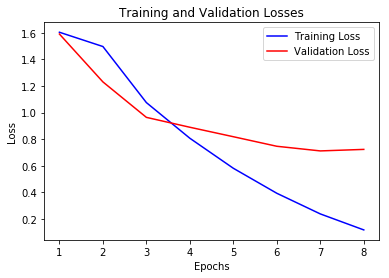

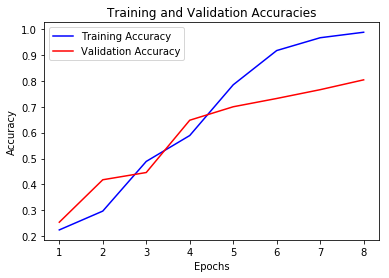

In [10]:
history_dict = history.history

loss = history_dict['loss']
accuracy = history_dict['accuracy']
val_loss = history_dict['val_loss']
val_accuracy = history_dict['val_accuracy']

epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(epochs, accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracies')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [11]:
def predict(model, text, LABEL, encoder):
    encoded_text = encoder.encode(text)
    prediction = model.predict(tf.expand_dims(encoded_text, 0))
    index = np.argmax(prediction)
    label = LABEL[index]
    return label

# Predict
df_test = pd.read_csv('data/test.csv')

output_path = 'output.txt'
predictions = []
for text in df_test['Text']:
    single_predict = predict(model, text, LABEL, encoder)
    predictions.append(single_predict)
np.savetxt(output_path, predictions, fmt='%s')
print('\nFinish predicting. Outputs are saved in %s.' % output_path)


Finish predicting. Outputs are saved in output.txt.
